# Simple use case for CML data from the OpenMRG dataset

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
import pycomlink as pycml
import tqdm

## Load data a small piece of data from the OpenMRG dataset
please refer to [Explore existing open datasets](./Explore_existing_datasets.ipynb) on how to dowload and explore the whole datset.

In [2]:
cmls = xr.open_dataset('data/openMRG_example.nc')

The dataset consists of transmitted (tsl) and recieved (rsl) signal levels for one day with one minute resolution. The meta data includes length, frequency and location of all both nodes of each CML.

In [3]:
cmls

<xarray.Dataset>
Dimensions:       (cml_id: 364, time: 1440)
Coordinates:
  * cml_id        (cml_id) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364
    sublink_id    object ...
  * time          (time) datetime64[ns] 2015-08-27 ... 2015-08-27T23:59:00
    length        (cml_id) float64 ...
    site_0_lat    (cml_id) float64 ...
    site_0_lon    (cml_id) float64 ...
    site_1_lat    (cml_id) float64 ...
    site_1_lon    (cml_id) float64 ...
    frequency     (cml_id) float64 ...
    polarization  (cml_id) object ...
Data variables:
    rsl           (cml_id, time) float64 ...
    tsl           (cml_id, time) float64 ...
Attributes:
    title:                 NA
    file author(s):        NA
    institution:           NA
    date:                  NA
    source:                NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA
    comment:               NA

## Simple processing using pycomlink
the steps are briefily explained in the next cell, for detailed explanation see [Basic example of using pycomlink](./pycomlink_basic_example.ipynb)


In [4]:
# calculate total loss
cmls["tl"] = cmls.tsl - cmls.rsl
# seperate periods of rain from dry time steps
cmls["wet"] = cmls.tl.rolling(time=60, center=True).std(skipna=False) > 0.8
# estiamte the baseline during rain events
cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=cmls.tl,
    wet=cmls.wet,
    n_average_last_dry=5,
)
# compenmsate for wet antenna attenuation
cmls["waa"] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cmls.tl,
    baseline=cmls.baseline,
    wet=cmls.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)
# calculate attenuation caused by rain and remove negative attenuation
cmls["A"] = cmls.tl - cmls.baseline - cmls.waa
cmls["A"].values[cmls.A < 0] = 0
# derive rain rate via the k-R relation
cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cmls.A,
    L_km=cmls.length.astype(float),
    f_GHz=cmls.frequency,
    pol=cmls.polarization,
)

#### Compare attenuation time series to derived rain rate for one CML

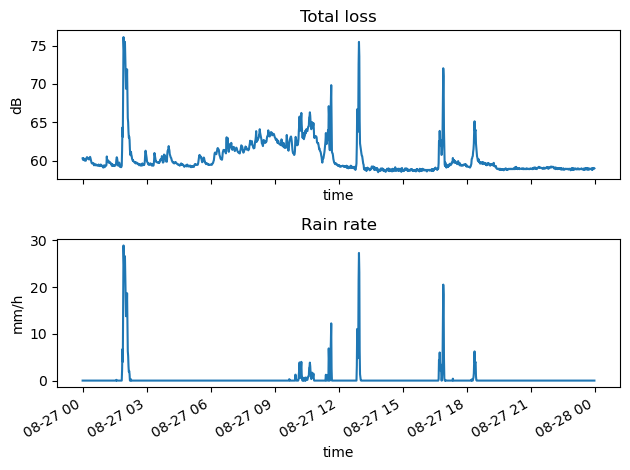

In [5]:
fig,ax = plt.subplots(2,1,sharex=True)
cmls.tl.isel(cml_id=90).plot(ax=ax[0])
ax[0].set_ylabel('dB')
ax[0].set_title('Total loss')
cmls.R.isel(cml_id=90).plot(ax=ax[1])
ax[1].set_ylabel('mm/h')
ax[1].set_title('Rain rate')
plt.tight_layout()

#### Remove some very short CMLs (< 1 km) with frequency below 30 GHz
which often can show unreasonable high rainfall values. This behavior might stem from an underestimation of WAA but is not entirely clear

In [6]:
cmls_sel = cmls.where(~((cmls.length<2) & (cmls.frequency<30)),drop=True)
cmls_sel = cmls_sel.where(cmls.length>1,drop=True)

## Interpolate hourly CML rainfall estimates

In [7]:
# resampling to one hour
cmls_R_1h = cmls_sel.R.resample(time='1h', label='right').mean().to_dataset()
# extracting center point of each CML which is used in IDW
cmls_R_1h['lat_center'] = (cmls_R_1h.site_0_lat + cmls_R_1h.site_1_lat)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_0_lon + cmls_R_1h.site_1_lon)/2
# define IDW parameters
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3,
)
# do the interpolation for every hour of the sample day
R_grid_list=[]
for t in tqdm.tqdm(cmls_R_1h.time):
    R_grid_list.append(idw_interpolator(
        x=cmls_R_1h.lon_center, 
        y=cmls_R_1h.lat_center, 
        z=cmls_R_1h.R.sel(time=t), 
        resolution=0.01,
    ))
# sum up hourly maps to one day
cml_rain_sum=np.array(R_grid_list).sum(axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:47<00:00,  1.99s/it]


#### Plot the daily rainfall sum and the CML paths

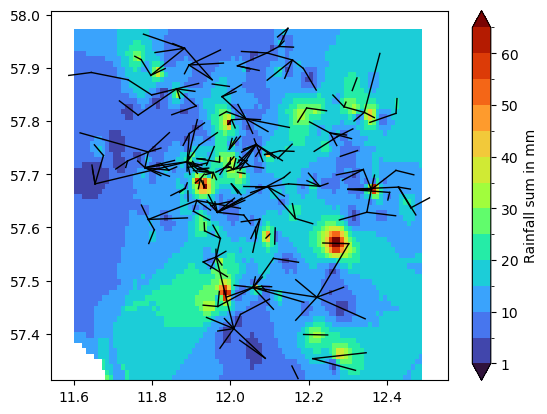

In [8]:
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_0_lon, ds_cmls.site_1_lon],
        [ds_cmls.site_0_lat, ds_cmls.site_1_lat],
        'k',
        linewidth=1,
    )
bounds = np.arange(0, 70, 5.0)
bounds[0] = 1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
   
fig,ax=plt.subplots()
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    cml_rain_sum, 
    shading='nearest', 
    cmap='turbo',
    norm=norm,
)
plot_cml_lines(cmls_R_1h, ax=ax)
fig.colorbar(pc, label='Rainfall sum in mm');

#### Hourly rainfall maps 

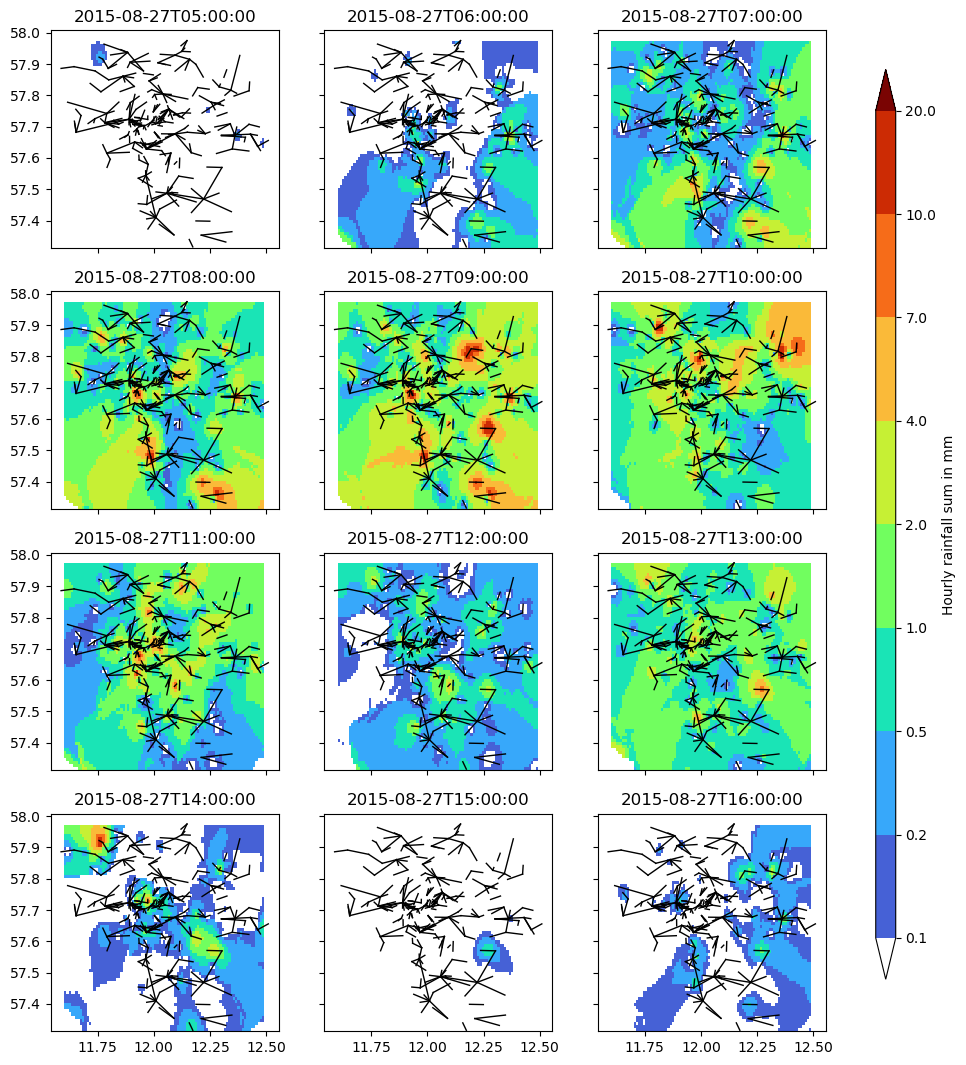

In [9]:
fig, ax = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(10, 13))

bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
cmap = plt.get_cmap('turbo').copy()
cmap.set_under('w')

for i, axi in enumerate(ax.flat):
    pc = axi.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid_list[i+4], 
        shading='nearest', 
        cmap=cmap,
        norm=norm,
    )
    axi.set_title(str(cmls_R_1h.time.values[i + 4])[:19])
    
    plot_cml_lines(cmls_R_1h, ax=axi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm', );



#### Animation of 24 hours of rainfall

In [10]:
import matplotlib.animation as animation

fig = plt.figure()

extent=[
    idw_interpolator.xgrid.min(),
    idw_interpolator.xgrid.max(),
    idw_interpolator.ygrid.min(),
    idw_interpolator.ygrid.max()]

ax = plt.axes()
im = ax.imshow(R_grid_list[0], cmap=cmap, norm=norm, origin="lower", extent=extent)
plt.plot(
    [cmls_sel.site_0_lon, cmls_sel.site_1_lon],
    [cmls_sel.site_0_lat, cmls_sel.site_1_lat],
    "k",
    linewidth=1,
)
im.set_data(np.zeros(R_grid_list[0].shape))
cbar = fig.colorbar(im)
title = ax.text(
    0.5,
    01.05,
    "",
    bbox={"facecolor": "w", "alpha": 0.5, "pad": 5},
    transform=ax.transAxes,
    ha="center",
)


def update_data(n):
    grid = R_grid_list[n]  # More random data
    im.set_data(grid)
    title.set_text("{}".format(str(cmls_sel.isel(time=n).time.values)[:19]))
    return title


ani = animation.FuncAnimation(fig, update_data, frames=len(R_grid_list))
plt.close()
from IPython.display import HTML
HTML(ani.to_jshtml())